In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 101kB/s 
     |████████████████████████████████| 501kB 44.8MB/s 
     |████████████████████████████████| 3.1MB 29.4MB/s 
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

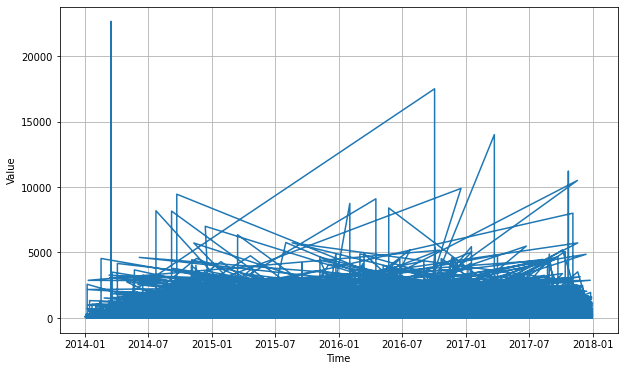

In [6]:
import csv
import pandas as pd
time_step = []
sales = []

'''with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1'''


df=pd.read_excel("/content/verticalstack_new.xlsx")
time_step=df["Order Date"]
sales=df["Sales"]

series = np.array(sales)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

#-----------------Model Building------------------------#

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#--------Callbacks to reduce epochs---------------------#
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#--------Optimizer----------------#
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


#------------------Compiling the model-------------------#
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#----------Model Fitting_--------------------#
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 669ms/step - loss: 266.7545 - mae: 268.8235
Epoch 2/100
10/10 [==============================] - 4s 383ms/step - loss: 266.0542 - mae: 267.9875
Epoch 3/100
10/10 [==============================] - 4s 385ms/step - loss: 264.8042 - mae: 266.7376
Epoch 4/100
10/10 [==============================] - 4s 377ms/step - loss: 263.3439 - mae: 265.2744
Epoch 5/100
10/10 [==============================] - 4s 390ms/step - loss: 261.7503 - mae: 263.6752
Epoch 6/100
10/10 [==============================] - 4s 389ms/step - loss: 260.0669 - mae: 261.9848
Epoch 7/100
10/10 [==============================] - 4s 375ms/step - loss: 258.3162 - mae: 260.2247
Epoch 8/100
10/10 [==============================] - 4s 375ms/step - loss: 256.5229 - mae: 258.4214
Epoc

(1e-08, 0.0001, 0.0, 60.0)

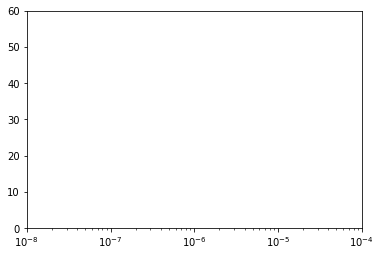

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 6s 239ms/step - loss: 245.1026 - mae: 246.2172
Epoch 2/150
25/25 [==============================] - 3s 133ms/step - loss: 231.1043 - mae: 232.0062
Epoch 3/150
25/25 [==============================] - 3s 132ms/step - loss: 224.9004 - mae: 225.7544
Epoch 4/150
25/25 [==============================] - 3s 132ms/step - loss: 220.8204 - mae: 221.6740
Epoch 5/150
25/25 [==============================] - 3s 134ms/step - loss: 217.1683 - mae: 218.0212
Epoch 6/150
25/25 [==============================] - 3s 134ms/step - loss: 214.7327 - mae: 215.5587
Epoch 7/150
25/25 [==============================] - 3s 134ms/step - loss: 211.3532 - mae: 212.1874
Epoch 8/150
25/25 [==============================] - 3s 134ms/step - loss: 209.2792 - mae: 210.1073
Epoch 9/150
25/25 [==============================] - 3s 136ms/step - loss: 206.9608 - mae: 207.7819
Epoch 10/150
25/25 [==============================] - 3s 133ms/step - loss: 203.9459 - mae: 204.7736

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

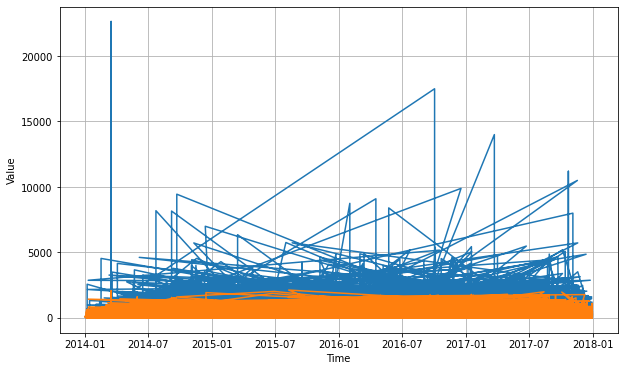

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)